In [7]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D
pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
from statsmodels.tsa.seasonal import seasonal_decompose
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
series = series[~series.isnull()]


def clean_data(data, threshold = 2500):
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #the data is in a Series, check that it is of type numeric
        v = data.values
        is_numeric = np.issubdtype(v.dtype, np.number)
        if is_numeric is False:
            raise TypeError("Your Series data needs to be numeric.")
        else:
         #the data is in the correct format, check that the threshold is an int
            if isinstance(threshold, int) is False:
                raise TypeError("Your passed threshold needs to be an int.")
            else:
                #actually clean the data
                cleaned_data = data[data.values > threshold]
    return cleaned_data

  
    
def split_data(data, split = 0.7):
    #check that our data is still a Series
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        v = data.values
        is_numeric = np.issubdtype(v.dtype, np.number)
        if is_numeric is False:
            raise TypeError("Your data needs to be numeric.")
        else:
            #check that split is a float value
            if isinstance(split, float) is False:
                raise TypeError("Your split value needs to be a float.")
            else:
                #check that split is 0.0 < x < 1.0
                if not 0.0 < split < 1.0:
                    raise ValueError("Split value needs to be between 0.0 and 1.0")
                else:
                    #split data in time format, not randomly shuffled
                    length_training = split * len(data)
                    length_training = int(round(length_training, 0))
                    training = data[0:length_training]
                    testing = data[length_training:len(data)]
    return training, testing
                

def decompose_data(data, method = "bfill"):
    #ensure that our data is in the proper format
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #check that their data has a datetime index
        if type(data.index) is not pd.core.indexes.datetimes.DatetimeIndex:
            raise TypeError("Series index needs to be in DateTime format.")
        else:
        #ensure data is in hourly format
        #check that their method is one of bfill or ffill
            if method is not "bfill" and method is not "ffill":
                raise TypeError("Method needs to be of type either bfill or ffill.")
            else:
                #may need to add check that data.values are of type int
                hourly = data.asfreq("H", method=method)
                #decompose the data
                result = seasonal_decompose(hourly)
                trend = result.trend
                trend = result.trend.fillna(result.trend.mean())
                seasonality = result.seasonal
                seasonality = seasonality.fillna(seasonality.mean())
                resid = result.resid
                resid = resid.fillna(resid.mean())
                decomposed_df = pd.DataFrame(dict(Data = hourly.values, Trend = trend.values, 
                                                 Seasonality = seasonality.values, Noise = resid.values))
                #make the index using any one of the Timestamps, since they are equivalent
                decomposed_df.index = hourly.index    
                #plot the data as part of what is returned
                decomposed_df.plot()
            
    return decomposed_df
    
#a function that combines all three, returns decomposed of clean training and non-cleaned testing      
def split_clean_and_decompose(data, method = "bfill", split_percentage = 0.7, threshold=2500):
    #ensure that our data is in the proper format
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #check that their data has a datetime index, or else we can't decompose it
        if type(data.index) is not pd.core.indexes.datetimes.DatetimeIndex:
            raise TypeError("Series index needs to be in DateTime format.")
        else:
            #ensure that data is of type numeric for cleaning - i.e. the Series is not strings, or else we can't clean it
            v = data.values
            is_numeric = np.issubdtype(v.dtype, np.number)
            if is_numeric is False:
                raise TypeError("Your Series data needs to be numeric.")
            else:
          #ensure data is in hourly format
          #check that their method is one of bfill or ffill
                if method is not "bfill" and method is not "ffill":
                    raise TypeError("Method needs to be of type either bfill or ffill.")
                else:
                    #check that split percentage is a float 0.0 < x < 1.0, or else we can't split it
                    if isinstance(split_percentage, float) is False:
                        raise TypeError("Split percentage needs to be a float.")
                    else:
                        if not 0.0 < split_percentage < 1.0:
                            raise ValueError("Split value needs to be between 0.0 and 1.0")
                        else:
                        #check that threshold is an int
                            if isinstance(threshold, int) is False:
                                raise TypeError("Your passed threshold needs to be an int.")
                            else:
                            #split the data
                                length_training = split_percentage * len(data)
                                length_training = int(round(length_training, 0))
                                training = data[0:length_training]
                                testing = data[length_training:len(data)]
                                #clean the training data
                                training = training[training.values > threshold]
                                #recombine to decompose them
                                combined = pd.concat([training, testing])    
                                #may need to add check that data.values are of type int
                                hourly = combined.asfreq("H", method=method)
                                #decompose the data
                                result = seasonal_decompose(hourly)
                                trend = result.trend
                                trend = trend.fillna(result.trend.mean())
                                seasonality = result.seasonal
                                seasonality = seasonality.fillna(seasonality.mean())
                                resid = result.resid
                                resid = resid.fillna(resid.mean())
                                decomposed_df = pd.DataFrame(dict(Data = hourly.values, Trend = trend.values, 
                                                 Seasonality = seasonality.values, Noise = resid.values))
                                #make the index using any one of the Timestamps, since they are equivalent
                                decomposed_df.index = hourly.index    
                                #plot the data as part of what is returned
                                decomposed_df.plot(figsize = (20, 10))
            
    return display(decomposed_df)



  

    

Grabbing WebIDs ...
WebID collection complete!
13:33:39: Sending API request... Chunk 1 of 1
13:33:41: Response recieved for 1 tags! (1.55)


# Example

,Data,Trend,Seasonality,Noise
Timestamp,,,,
2017-06-28 00:00:00,2676.141823,2844.672716,-179.122741,0.025808
2017-06-28 01:00:00,2660.262893,2844.672716,-194.062663,0.025808
2017-06-28 02:00:00,2660.319187,2844.672716,-200.963908,0.025808
2017-06-28 03:00:00,2679.009611,2844.672716,-205.472233,0.025808
2017-06-28 04:00:00,2692.048994,2844.672716,-206.837714,0.025808
2017-06-28 05:00:00,2682.391026,2844.672716,-207.430714,0.025808
2017-06-28 06:00:00,2712.313192,2844.672716,-185.926891,0.025808
2017-06-28 07:00:00,2842.247945,2844.672716,-116.409969,0.025808
2017-06-28 08:00:00,2951.976605,2844.672716,-25.154034,0.025808


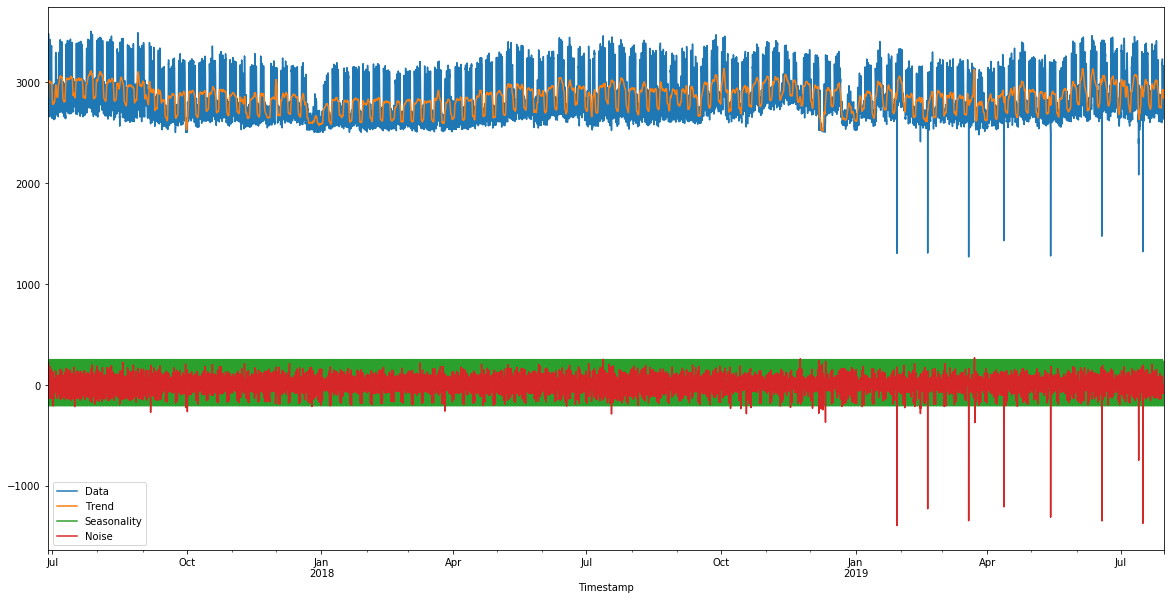

In [8]:
split_clean_and_decompose(series)